In [6]:
from datetime import datetime, timedelta
from dateutil import tz

from siphon.catalog import TDSCatalog
import xarray as xr
import metpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd

In [7]:
def roundTime(dt=None, roundTo=60):
    """Round a datetime object to any time lapse in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    if dt == None : dt = datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + timedelta(0,rounding-seconds,-dt.microsecond)

def convert_datetime_from_nomads_to_local(string):
    """Converts a datetime string from the NOMADS DODS server to Eastern
    It works most of the time
    Author: Ray Hawthorne 2019
    """
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    eastern = roundTime(eastern)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

In [14]:
radar = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km/latest.xml')
#print(radar.datasets)
radar_ds = radar.datasets[0].remote_access(use_xarray=True)
radar_ds = radar_ds.metpy.parse_cf()

[init_time, *rest] = radar_ds['time'].values
init_time = np.datetime_as_string(init_time)
init_time = convert_datetime_from_nomads_to_local(init_time.split('.')[0])

reflectivity = radar_ds['Composite_reflectivity_entire_atmosphere'].squeeze()
[Z_unpack, *rest] = reflectivity
plot_proj = reflectivity.metpy.cartopy_crs

#radar_ds.variables

In [10]:
location = plot_proj.transform_point(-81.31, 29.37, ccrs.PlateCarree())
x, y = location

point = reflectivity.metpy.sel(x=x, y=y, method='nearest')
print(point.values)
print(len(point.values))

[  4.062498   -3.437502    8.999998    1.3749981 -10.000002   -4.437502
 -10.000002  -10.000002  -10.000002  -10.000002  -10.000002  -10.000002
  -0.5000019   4.624998  -10.000002   -3.125002    4.437498  -10.000002
   2.312498 ]
19


/Users/rhawthorne/miniconda3/envs/metpy_v1/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/rhawthorne/miniconda3/envs/metpy_v1/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/rhawthorne/miniconda3/envs/metpy_v1/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


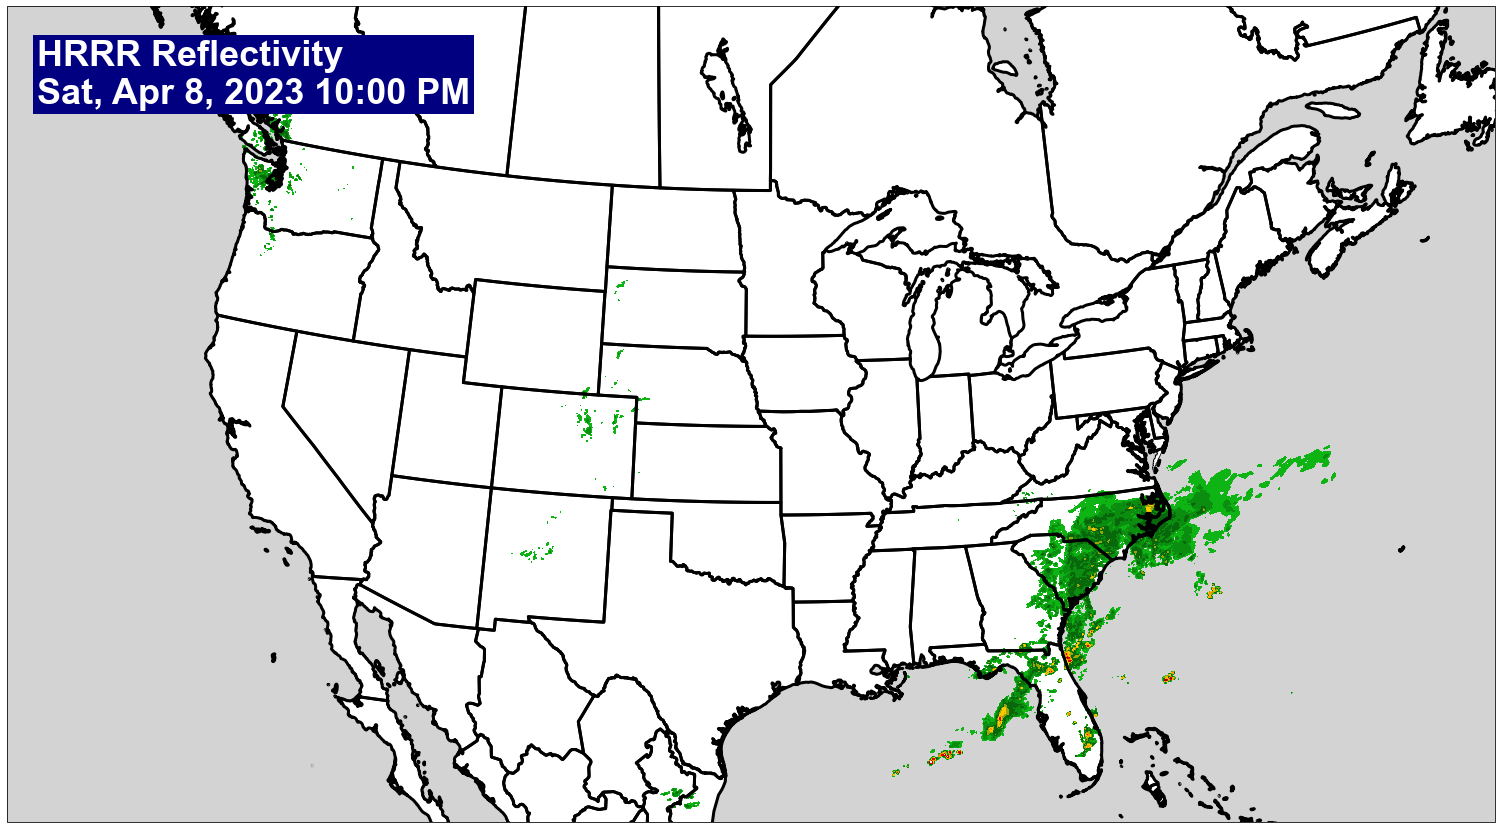

In [11]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_subplot(1, 1, 1, projection=plot_proj)
ax.set_extent((-122, -70, 24, 54), crs=ccrs.PlateCarree())
#ax.set_extent((-85, -78, 28, 32), crs=ccrs.PlateCarree())


# Add state lines, coastlines, map extent
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=3.00, zorder=2)
ax.set_adjustable('datalim')

# Define Colormap
norm, cmap = metpy.plots.ctables.registry.get_with_steps('NWSStormClearReflectivity', 20, 5)

# Display Banner
plt.text(0.02, 0.96, s=f'HRRR Reflectivity\n{init_time}',
         fontname='Arial', fontsize=36, fontweight='bold', color='white',
         bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none'},
         transform=ax.transAxes, zorder=10, va='top')

ax.contourf(reflectivity.metpy.x, reflectivity.metpy.y, Z_unpack, np.arange(20, 80, 5),
            cmap=cmap, norm=Normalize(-30, 80), transform=plot_proj,)
